<a href="https://colab.research.google.com/github/Christian-Stefan/Team-Internship/blob/Chris/DataReconstructionDemo_v0.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Reconstruction

## Add dependencies

In [2]:
# !pip install SimpleITK
# !pip install pydicom
# !pip install helpers
%matplotlib inline


import matplotlib.pyplot as plt

from ipywidgets import interact
import cv2
import numpy as np
import pydicom
import json
import SimpleITK as stk
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from skimage import measure
from PIL import Image, ImageDraw

## Load sample

In [4]:
def load_dicom_series(path:str)-> (stk.SimpleITK.Image,
                                   stk.SimpleITK.ImageSeriesReader):
  """
  load_dicom_Series used primarily to initialize the stk-related object that can
  be used to:
  * read DICOM file(s) and their annotations;
  \\ reader = stk.ImageSeriesReader() -> reade.GetGDCM...
  * attach to each CT a unique identifier and stack the counted CTs in a
  container (e.g., image)

  :path:str -> path to be accessed when reading the dicom file(s)
  :return:
  """

  #1 Initialize the sitk class - ImageSeriesReade
  reader = stk.ImageSeriesReader()
  dicom_names = reader.GetGDCMSeriesFileNames(path)
  reader.SetFileNames(dicom_names)
  image = reader.Execute()

  return image, reader

"""
Example:
-------
image, reader = load_dicom_Series('/content/')
print(image)
>>> Size: [512, 512, 103] ...
print(type(reader),reader)
 >>> <class 'SimpleITK.SimpleITK.ImageSeriesReader'> itk::simple::ImageSeriesReader
 >>> FileNames:
 >>>   "/content/1-0001.dcm"
 >>>   "/content/1-0002.dcm"
------
"""

'\nExample:\n-------\nimage, reader = load_dicom_Series(\'/content/\')\nprint(image)\n>>> Size: [512, 512, 103] ...\nprint(type(reader),reader)\n >>> <class \'SimpleITK.SimpleITK.ImageSeriesReader\'> itk::simple::ImageSeriesReader\n >>> FileNames:\n >>>   "/content/1-0001.dcm"\n >>>   "/content/1-0002.dcm"\n------\n'

## Inhereted - image reader - utility

In [ ]:
def explore_3D_array(arr: np.ndarray, cmap: str = 'gray'):
  """
  Given a 3D array with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D array.
  The purpose of this function to visual inspect the 2D arrays in the image.

  Args:
    arr : 3D array with shape (Z,X,Y) that represents the volume of a MRI image
    cmap : Which color map use to plot the slices in matplotlib.pyplot
  """

  def fn(SLICE):
    plt.figure(figsize=(7,7))
    plt.imshow(arr[SLICE, :, :], cmap=cmap)
    plt.show()

  interact(fn, SLICE=(0, arr.shape[0]-1))

def explore_3D_array_comparison(arr_before: np.ndarray, arr_after: np.ndarray, cmap: str = 'gray'):
  """
  Given two 3D arrays with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D arrays.
  The purpose of this function to visual compare the 2D arrays after some transformation.

  Args:
    arr_before : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, before any transform
    arr_after : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, after some transform
    cmap : Which color map use to plot the slices in matplotlib.pyplot
  """

  assert arr_after.shape == arr_before.shape
  @staticmethod
  def fn(SLICE):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,10))

    ax1.set_title('Before', fontsize=15)
    ax1.imshow(arr_before[SLICE, :, :], cmap=cmap)

    ax2.set_title('After', fontsize=15)
    ax2.imshow(arr_after[SLICE, :, :], cmap=cmap)

    plt.tight_layout()
    plt.show()

  interact(fn, SLICE=(0, arr_before.shape[0]-1))


# Preprocessing

## Rescaling - Obosolete Momemntarily

In [ ]:
def Rescaling(image:stk.SimpleITK.Image, values:list =[0,255])->np.ndarray:
  """

  :param image:
  :param values: By default is [0, 1]
  :return:
  """
  transformed = stk.RescaleIntensity(image, values[0], values[1])

  return transformed

## Binarization - Obosolete Momentariliy

In [ ]:
def Binarization(image:stk.SimpleITK.Image, values:list =[0,1])->np.ndarray:
  """

  :param image:
  :param values: By default is [0, 1]
  :return:
  """
  transformed = stk.OtsuThreshold(image, values[0], values[1])

  return transformed

## Pipeline pre-processing

In [ ]:
class Preprocessing:
    def __init__(self, explore: bool = False):
        """
        Parameters:
            explore (bool): If True, will show comparisons after each step.
        """
        self.explore = explore

    def _explore(self, before, after):
        """Internal method for visualization, guarded by the flag."""
        if self.explore:
            explore_3D_array_comparison(
                arr_before=stk.GetArrayFromImage(before),
                arr_after=stk.GetArrayFromImage(after)
            )

    def median_filter(self, image):
        filtered = stk.Median(image, [3, 3, 3])
        self._explore(image, filtered)
        return filtered

    def binarize(self, image):
        binarized = Binarization(image)
        self._explore(image, binarized)
        print("Binarization - Before: Max-{} Min-{}\n After: Max-{} Min_{}".format(
            stk.GetArrayFromImage(image).max(), stk.GetArrayFromImage(image).min(),
            stk.GetArrayFromImage(binarized).max(), stk.GetArrayFromImage(binarized).min()))
        return binarized

    def rescale(self, image):
        rescaled = Rescaling(image)
        self._explore(image, rescaled)
        return rescaled

    def run_pipeline(self, ct_image):
        """
        Full preprocessing pipeline.
        Returns:
            rescaled image and flattened array.
        """
        step1 = self.median_filter(ct_image)
        step2 = self.binarize(step1)
        step3 = self.rescale(step2)
        flattened = stk.GetArrayFromImage(step3).flatten()
        return step3, flattened

## 3D Mask Builder

In [ ]:
def build_3D_mask_from_json(json_path, image_size):
    """

    """
    #. 1 Reading `r` the .json file:
    with open(json_path, 'r') as f:
        data = json.load(f)

    #. 2 Storing the deepness (e.g., z axis length) in variable `num_annotated_slices`
    num_annotated_slices = len(data['annotation'])

    #. 3 Building the nodule box by factoring in:
    # `z axis` -> num_annotated_slices
    # `x axis` -> image_size[1]
    # `y axis` -> image_size[2]
    volume = np.zeros((num_annotated_slices, image_size[1], image_size[0]), dtype=np.uint8)


    # 4 Establishing the mask by 2-step iterative method
    # 4.1 Used enumeration b.in method to:
    # index `z aka deepness`
    # coordinates (x,y)
    for z, slice_dict in enumerate(data['annotation']):
        key = list(slice_dict.keys())[0]
        polygons = slice_dict[key]['segmentation']

        for polygon in polygons:
            coords = np.array(polygon).reshape(-1, 2)
            coords[:, 0] *= image_size[0]
            coords[:, 1] *= image_size[1]
            coords[:, 0] = np.clip(coords[:, 0], 0, image_size[0] - 1)
            coords[:, 1] = np.clip(coords[:, 1], 0, image_size[1] - 1)
            coords = coords.astype(np.int32)
            cv2.fillPoly(volume[z], [coords], color=1)

    return volume


data_path = '/content/'
ct_image, constructor_stk = load_dicom_Series(data_path)
json_path:str = '/content/segmentation_00000.json'
image_size = ct_image.GetSize()[:2] # Width/Length

build_3D_mask_from_json(json_path, image_size)

<class 'dict'>
{'53': {'zpos': 0.09898287057876587, 'sliceLocation': 106.0, 'dicomFile': 'Q:/_Research_Demos/2244_09_CT_LungNodules/Content/Houdini/data/20241221_074106/LIDC-IDRI/LIDC-IDRI-0000/01-01-2000-NA-NA-02587/3976134.000000-NA-94964/1-0053.dcm', 'segmentation': [[0.5912140011787415, 0.597094714641571, 0.5955161452293396, 0.5961835384368896, 0.5950999855995178, 0.599096953868866, 0.5980092287063599, 0.5992285013198853, 0.6005939841270447, 0.5977995991706848, 0.6024193167686462, 0.5995777249336243, 0.6009725332260132, 0.6010118722915649, 0.6004446148872375, 0.6050024628639221, 0.5978322625160217, 0.6068586707115173, 0.5994653105735779, 0.6079736351966858, 0.599357008934021, 0.6103476285934448, 0.597094714641571, 0.6091064810752869, 0.5954642295837402, 0.6070365905761719, 0.5926246643066406, 0.6069517135620117, 0.5902431607246399, 0.6072597503662109, 0.5890868902206421, 0.6051025390625, 0.5850316286087036, 0.6063857674598694, 0.583341121673584, 0.6035141944885254, 0.58421385288238

NameError: name 'cv2' is not defined

## 3D Mask Plotting

In [ ]:
def visualize_3D_mask(volume):

    # Test 2
    if np.max(volume) == 0:
        print("Warning: Volume contains no segmented voxels.")
        return

    verts, faces, normals, values = measure.marching_cubes(volume, level = 0.9)
    print("Verts:", verts.shape, "Faces:", faces.shape)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    verts_swapped = verts[:, [2, 1, 0]]
    mesh = Poly3DCollection(verts_swapped[faces], alpha=0.7, facecolor="orange")
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

    filled = np.argwhere(volume)
    zmin, ymin, xmin = filled.min(axis=0)
    zmax, ymax, xmax = filled.max(axis=0)

    ax.set_xlim(xmin - 10, xmax + 10)
    ax.set_ylim(ymin - 10, ymax + 10)
    ax.set_zlim(zmin - 1, zmax + 1)

    ax.set_xlabel("coord x")
    ax.set_ylabel("coord y")
    ax.set_zlabel("number of slices")
    #plt.tight_layout()
    plt.show()

# Extract VOI - Obosolete

In [ ]:
def extract_nodule_Region(ct_image, mask):
  ct_array = stk.GetArrayFromImage(ct_image)
  nodule_array = ct_array * mask
  return nodule_array

# Rendering - Obosolete

In [ ]:
# def plot_3d(volume, threshold=0):
#     verts, faces, _, _ = measure.marching_cubes(volume, level=threshold)

#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')

#     mesh = Poly3DCollection(verts[faces], alpha=0.7)
#     mesh.set_facecolor('gray')
#     mesh.set_edgecolor('k')
#     ax.add_collection3d(mesh)
#     ax.set_xlim(0, volume.shape[2])
#     ax.set_ylim(0, volume.shape[1])
#     ax.set_zlim(0, volume.shape[0])
#     ax.view_init(elev=30, azim=45)
#     plt.tight_layout()
#     plt.show()

# def plot_3d(volume, threshold=0):
#     verts, faces, _, _ = measure.marching_cubes(volume, level=threshold)

#     # Optional real-world scaling
#     spacing = (1.0, 1.0, 2.0)  # Replace with ct_image.GetSpacing()[::-1] if needed
#     verts[:, 0] *= spacing[0]
#     verts[:, 1] *= spacing[1]
#     verts[:, 2] *= spacing[2]

#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')

#     mesh = Poly3DCollection(verts[faces])
#     mesh.set_facecolor('lightcoral')  # 'gray' or any Matplotlib color
#     mesh.set_edgecolor('k')
#     mesh.set_alpha(0.9)
#     ax.add_collection3d(mesh)

#     # Auto-scaling view
#     ax.auto_scale_xyz(
#         [0, volume.shape[2] * spacing[2]],
#         [0, volume.shape[1] * spacing[1]],
#         [0, volume.shape[0] * spacing[0]]
#     )
#     ax.view_init(elev=30, azim=45)
#     ax.grid(False)
#     plt.tight_layout()
#     plt.show()

# Crop Nodule - Obosolete

In [ ]:
# def crop_to_nodule_box(nodule_volume):
#   coords = np.argwhere(nodule_volume > 0)

#   # Check
#   if coords.size == 0:
#     raise ValueError("No Nodule")

#   zmin, ymin, xmin = coords.min(axis=0)
#   zmax, ymax, xmax = coords.max(axis=0) + 1

#   cropped_nodule = nodule_volume[zmin:zmax, ymin:ymax, xmin:xmax]
#   print("Croppsed volume shape", cropped_nodule.shape)
#   return cropped_nodule

# Pipeline - Obosolete


In [ ]:
# Add dependencies
OUTPUT_PATH_GZ = '/content/output/ct_scan.nii.gz'
# Set path
data_path:str = '/content/sample_data/LIDC-IDRI-0000'
json_path:str = '/content/sample_data/LIDC-IDRI-0000/segmentation_00000.json'

# Crafted my own preprocessing sequence until the modular pipeline comes out
# 2. Preprocessing
# 2.1 Median Filter
# ct_image_filtered = stk.Median(ct_image, [3, 3, 3])
# explore_3D_array_comparison(arr_before=stk.GetArrayFromImage(ct_image),
#                             arr_after=stk.GetArrayFromImage(ct_image_filtered))
# # 2.2 Binnarization
# ct_image_binarized = Binarization(ct_image_filtered)
# explore_3D_array_comparison(arr_before=stk.GetArrayFromImage(ct_image_filtered),
#                             arr_after= stk.GetArrayFromImage(ct_image_binarized))
# print("Binarization - Before: Max-{} Min-{}\n After: Max-{} Min_{}".format(stk.GetArrayFromImage(ct_image).max(),stk.GetArrayFromImage(ct_image).min(),
#                                                                     stk.GetArrayFromImage(ct_image_binarized).max(),stk.GetArrayFromImage(ct_image_binarized).min()))
# # 2.3 Rescalling
# ct_image_rescale = Rescaling(ct_image_binarized)
# explore_3D_array_comparison(arr_before=stk.GetArrayFromImage(ct_image_binarized),
#                             arr_after=stk.GetArrayFromImage(ct_image_rescale))
# flattened = stk.GetArrayFromImage(ct_image).flatten()

# plt.figure(figsize=(8, 5))
# plt.hist(flattened, bins=100, color='blue', alpha=0.7)
# plt.title('CT Image Intensity Histogram')
# plt.xlabel('Hounsfield Units (HU)')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()


# # 3. Extract nodule gra-level regon
# nodule_volume = extract_nodule_Region(ct_image, mask_3d)


# # 3.1 Down scale to the box of the actual nodule
# cropped_nodule = crop_to_nodule_box(nodule_volume)

# print("Volume shape ",nodule_volume.shape)
# print("Non-zero voxel count ",np.count_nonzero(nodule_volume))
# print("Value range ",np.min(nodule_volume), np.max(nodule_volume))

# # 4. Rendering and Display
# non_zero = nodule_volume[nodule_volume>0]
# plot_3d(cropped_nodule, threshold=np.percentile(non_zero, 30))



# Curent pipeline

CT Size (512, 512, 103)
No. Slices 103
Verts: (899, 3) Faces: (1712, 3)


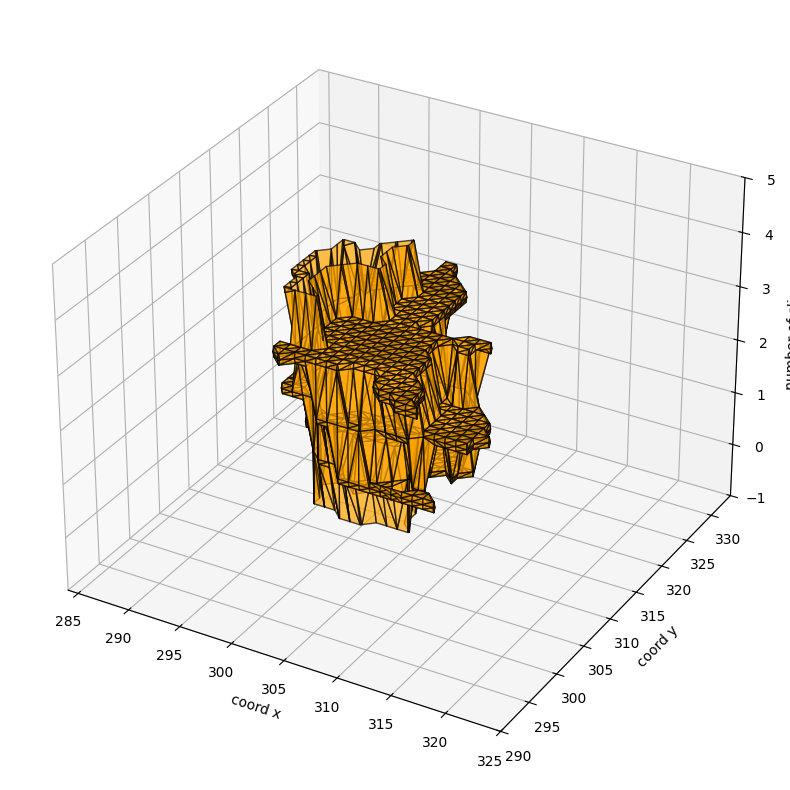

In [ ]:
# Add dependencies
OUTPUT_PATH_GZ = '/content/output/ct_scan.nii.gz'
# Set path
data_path:str = '/content/sample_data/LIDC-IDRI-0000'
json_path:str = '/content/sample_data/LIDC-IDRI-0000/segmentation_00000.json'
#TODO Create separate utility for dependencies (e.g, folder)
#TODO Create .requirements.txt
#TODO Create an automatized `reading path mechanism`


# 1. Load image volume
ct_image, constructor_stk = load_dicom_Series(data_path)
image_size = ct_image.GetSize()[:2] # Width/Length
no_slices = ct_image.GetSize()[2]
print("CT Size {}\nNo. Slices {}".format(ct_image.GetSize(), no_slices)) # Item description


#TODO Create separate utility for tests (e.g., folder)
# TEST 1 - Does the GetSize matche with inner array?
ct_image_arr_numpy = stk.GetArrayFromImage(ct_image)
try:
  img_init = image_size # back-up
  image_size = reversed(ct_image_arr_numpy.shape)
  image_size = img_init
except:
  print("Image's array does not match its real dimension")

# Crafted my own preprocessing sequence until the modular pipeline comes out -
# Commented out because Colab-GitHub conversion does not support widgets
# preproc = Preprocessing(explore=True)
# processed_image, flat = preproc.run_pipeline(ct_image)

# 2. Load segmentation & create mask
volume = build_3D_mask_from_json(json_path,
                                 image_size)


# 3. Plot mask as a 3d volume
visualize_3D_mask(volume)

DICOM series successfully accessed at ... '/content/sample_data_2'
3D Mask has been built
Verts: (899, 3) Faces: (1712, 3)


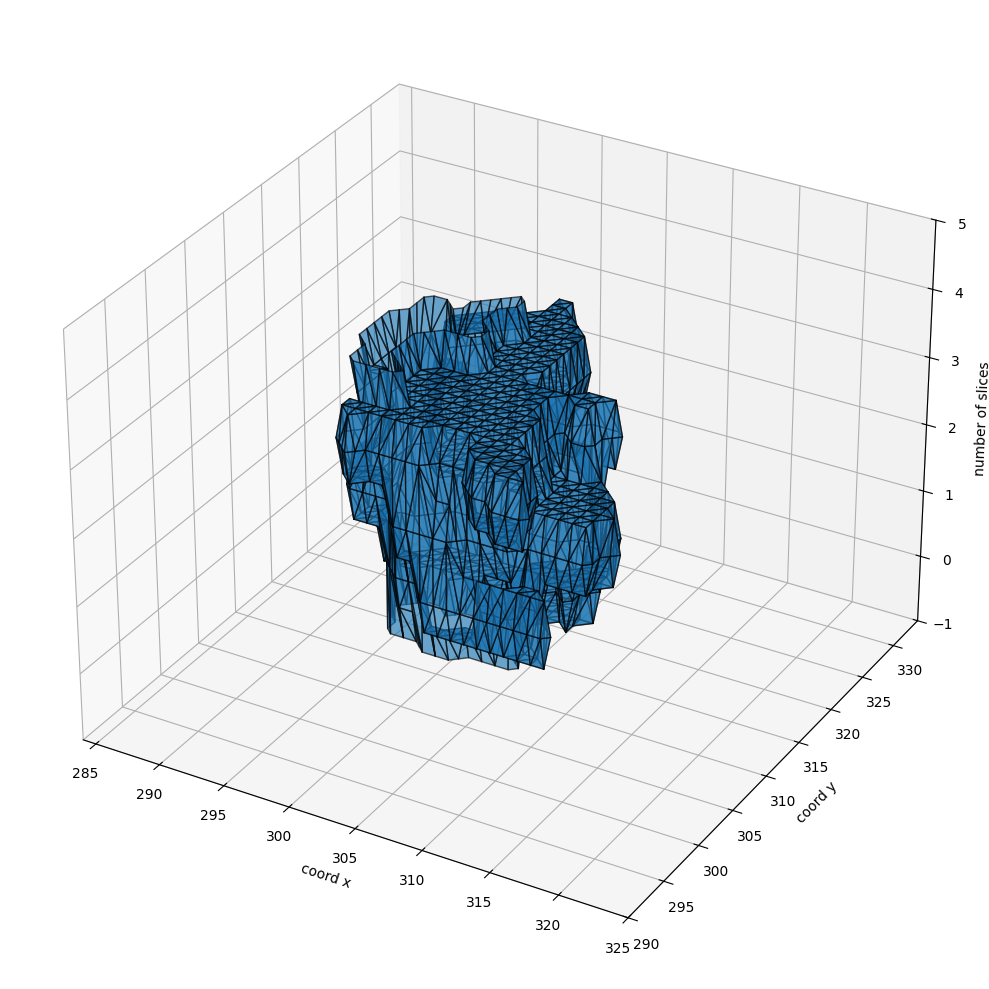

In [66]:
class Nodule_Reconstruction:
  def __init__(self,
               dcom_path:str, # Path of .dcm sequence (e.g., 1-0067.dcm, 1-0068.dcm ... 1-00nn.dcm)
               json_dcom_path:str, # Path of .json file (e.g., segmentation_00036.json)
               level_of_detail:int = None): # On a scale from 1 to 10 the level of detail directly influences the verts and faces number
    self.dcom_path = dcom_path
    self.json_dcom_path = json_dcom_path

    # -------- Data readings ----------- # STARTS
    self.image, self.reader = self.load_dicom_Series(self.dcom_path)
    print("DICOM series successfully accessed at ... '{}'".format(self.dcom_path))
    # -------- Data readings ----------- # ENDS

  def load_dicom_Series(self, path:str)-> (stk.SimpleITK.Image,
                                   stk.SimpleITK.ImageSeriesReader):
        """
        load_dicom_Series used primarily to initialize the stk-related object that can
        be used to:
        * read DICOM file(s) and their annotations;
        \\ reader = stk.ImageSeriesReader() -> reade.GetGDCM...
        * attach to each CT a unique identifier and stack the counted CTs in a
        container (e.g., image)

        :path:str -> path to be accessed when reading the dicom file(s)
        :AUTOMATIC:bool -> by default False meaning that path it's going to be used.
                           Otherwise path needs to be specify when calling in load_dicom_Series
        :return: image object which has comes with nice reading-type functions (e.g. image.GetSize())
                 pass over the SimpleITK initialized object in the case any update is needed
        """
        # 1. Initialize the sitk class - ImageSeriesReade
        reader = stk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(path)
        reader.SetFileNames(dicom_names)
        image = reader.Execute()

        return image, reader

        """
        Example:
        -------
        image, reader = load_dicom_Series('/content/')
        print(image)
        >>> Size: [512, 512, 103] ...
        print(type(reader),reader)
        >>> <class 'SimpleITK.SimpleITK.ImageSeriesReader'> itk::simple::ImageSeriesReader
        >>> FileNames:
        >>>   "/content/1-0001.dcm"
        >>>   "/content/1-0002.dcm"
        ------
        """

  def build_3d_Mask(self) -> np.ndarray:
    """
    build_3d_Mask it's employed only for extracting the `x, y and z`
    coordinates of a nodule defined by any dicom series at a given path

    :return: a 3D-matrix volume with shape (z, width, height)
    whose items contain (x,y) precise coordinates of the nodule
    """
    # 1. Open .json object in `r` mode:
    with open (self.json_dcom_path, 'r') as file:
      data = json.load(file) # 1.1. retrieving information (e.g., nodule's slices) out from loaded .json object

    # 2. Define the matrix-space based on `image sizes` and eventually `depth`
    num_annotated_slices = len(data['annotation'])
    volume = np.zeros((num_annotated_slices, self.image.GetSize()[1], self.image.GetSize()[0]), dtype=np.uint8)

    # 3. Itterating over `data` with `annotation` key in order to retrieve
    #(x, y) coordinates and z (e.g., deepness)\
    for z, slices in enumerate(data['annotation']): # 3.1. Extracting the number of slices (e.g., z axis)
      for slice in slices: # 3.2. Using the number indicating the exact slice to access the (x,y) coordinates
        coords = slices[slice]['segmentation'][0] # ...[0] to eliminate the nested lists

        # 4. Converting the list into a numpy array will help down the line
        coords = np.array(coords).reshape(-1,2) # ... to distribute coordinate on two separate columns
        coords[ :,0] *= self.image.GetSize()[0] # ... to independently multiply the x and y coordinate with the image maximum sizes
        coords[ :,1] *= self.image.GetSize()[1]

        # 5. Fill out the sparse-volume at each iteration:
        coords = coords.astype(np.int64) # 5.1. Change the coords type
        cv2.fillPoly(volume[z], [coords], color=1) # 5.2. Fill out the volume z

    print("3D Mask has been built")
    return volume

  def visualize_3d_Mask(self, volume):

    if np.max(volume) == 0:
      raise TypeError("Warning: Volume contains no segmented voxels.")

    # Vertices - a point where multiple lines meet
    # Faces - a flat triangle-surface which has exactly three veices
    # Normals - gradient direction which could be eiher positive or negative
    # Values - maximum gradient magnitude in the local region near each vertex

    # 1. Using marhcing cubes to extract verts, faces, normals and values
    verts, faces, normals, values = measure.marching_cubes(volume =volume,
                                                           level = None, # Uses the average of he min and max of volume
                                                           spacing=(1,1,1),
                                                           gradient_direction='descent',
                                                           allow_degenerate=False,
                                                           method='lorensen')

    print("Verts:", verts.shape, "Faces:", faces.shape)

    # 2. Building the plot
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111, projection='3d')
    verts_swapped = verts[:, [2, 1, 0]] # Inverting columns order to match M, N, P
    mesh = Poly3DCollection(verts_swapped[faces], alpha=0.65)
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

    filled = np.argwhere(volume)
    zmin, ymin, xmin = filled.min(axis=0)
    zmax, ymax, xmax = filled.max(axis=0)

    ax.set_xlim(xmin - 10, xmax + 10)
    ax.set_ylim(ymin - 10, ymax + 10)
    ax.set_zlim(zmin - 1, zmax + 1)

    ax.set_xlabel("coord x")
    ax.set_ylabel("coord y")
    ax.set_zlabel("number of slices")
    plt.tight_layout()
    plt.show()
    pass

nodule = Nodule_Reconstruction('/content/sample_data_2',
                               '/content/sample_data_2/segmentation_00000.json')
volume = nodule.build_3d_Mask()
nodule.visualize_3d_Mask(volume)
